# AMG+ for 1D Helmholtz: Automatic Choices for Coarsening
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [2]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point" # "3-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 20 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.2

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.299e+00                    4.471e-01    2.901
INFO     1     7.238e-01 (0.558) [0.558]    3.459e-01    2.094 (0.721)
INFO     2     4.215e-01 (0.583) [0.570]    2.975e-01    1.421 (0.678)
INFO     3     2.664e-01 (0.633) [0.590]    2.727e-01    0.982 (0.691)
INFO     4     1.841e-01 (0.692) [0.614]    2.580e-01    0.717 (0.731)
INFO     5     1.388e-01 (0.754) [0.640]    2.480e-01    0.563 (0.785)
INFO     6     1.126e-01 (0.811) [0.666]    2.406e-01    0.471 (0.837)
INFO     7     9.614e-02 (0.853) [0.690]    2.346e-01    0.412 (0.875)
INFO     8     8.494e-02 (0.883) [0.712]    2.296e-01    0.372 (0.903)
INFO     9     7.679e-02 (0.904) [0.731]    2.253e-01    0.343 (0.921)
INFO     10    7.056e-02 (0.919) [0.748]    2.215e-01    0.320 (0.935)
INFO     11    6.560e-02 (0.930) [0.763]    2.181e-01    0.302 (0.944)
INFO     12    6.154e-02 (0.938) [0.776]    2.150e-01    0.288 (0.952)
INFO 

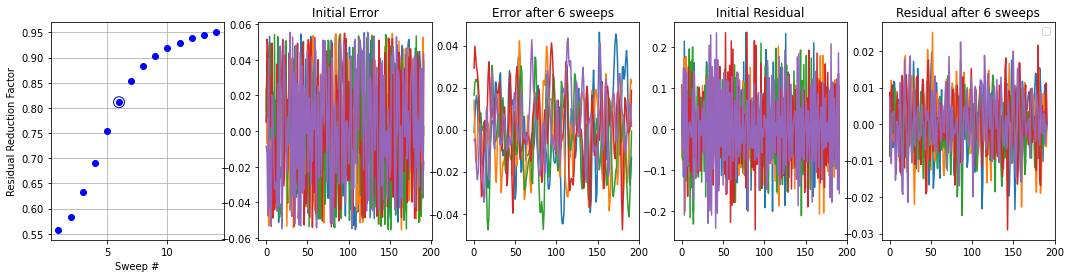

In [4]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["relax"][1]

### Coarsening: Fixed (4/2)
Measure local two-level rates on a domain of size $m=6$ aggregates.

In [5]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1
m = 8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4"  , 4, "q"),
    ("R A P caliber 4"  , 4, "r"),
]

all_conv, r, p, q = helmholtz.analysis.stats.compare_coarsening(
    level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_values=nu_values,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

p = p[4]

INFO     Generating 4 TVs with 20 sweeps
INFO     RER 0.208


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.5339,0.1373,0.1345,0.0882,0.0755,0.0813,0.0656,0.0457,0.0511,0.0468,0.0472
P^T A P caliber 2,1.1429,0.0000,0.3985,0.2998,0.4109,0.4186,0.3844,0.3772,0.3729,0.3605,0.3395,0.3299,0.2702
P^T A P caliber 3,1.2987,0.0000,0.5953,0.2816,0.2059,0.2737,0.2063,0.2200,0.2265,0.2170,0.2131,0.2082,0.2151
P^T A P caliber 4,1.7662,0.0000,0.3591,0.1551,0.1378,0.1131,0.0965,0.0691,0.0458,0.0342,0.0365,0.0344,0.0280
Q A P caliber 4,1.1429,0.0160,0.9909,0.3128,0.3105,0.1559,0.1231,0.0971,0.0908,0.1113,0.1052,0.0948,0.0930
R A P caliber 4,1.1429,0.0161,0.9137,0.2528,0.3077,0.1872,0.1230,0.0988,0.0800,0.0653,0.0499,0.0461,0.0471


In [6]:
# Using GMRES as as a coarse-level solver seems to be a robust choice vs. m (domain size).
m = 4
nu_coarsest = -1
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components, m=m)
two_level_conv = hm.repetitive.locality.two_level_conv_factor(
    ml, 3, nu_coarsest=nu_coarsest, print_frequency=1, debug=False, num_sweeps=8)

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      7.104e+00           2.626           2.705
INFO     1      1.906e+00  (0.268)  2.509  (0.955)  0.760
INFO     2      3.185e-01  (0.167)  2.372  (0.946)  0.134
INFO     3      9.310e-02  (0.292)  2.035  (0.858)  0.046
INFO     4      2.390e-02  (0.257)  2.469  (1.213)  0.010
INFO     5      4.872e-03  (0.204)  2.219  (0.899)  0.002
INFO     6      8.455e-04  (0.174)  2.912  (1.313)  0.000
INFO     7      1.480e-04  (0.175)  2.920  (1.003)  0.000
INFO     8      2.456e-05  (0.166)  2.184  (0.748)  0.000


In [7]:
# full domain 2-level convergence.
nu_coarsest = 100
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)
two_level_conv = hm.repetitive.locality.two_level_conv_factor(
    ml, 8, nu_coarsest=nu_coarsest, print_frequency=1, debug=False)

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.832e+01           2.441           11.602
INFO     1      1.472e+00  (0.052)  0.913  (0.374)  1.613
INFO     2      8.444e-02  (0.057)  0.059  (0.064)  1.436
INFO     3      1.039e-02  (0.123)  0.007  (0.124)  1.425
INFO     4      3.655e-03  (0.352)  0.003  (0.352)  1.423
INFO     5      1.501e-03  (0.411)  0.001  (0.411)  1.422
INFO     6      6.216e-04  (0.414)  0.000  (0.414)  1.422
INFO     7      2.576e-04  (0.414)  0.000  (0.414)  1.422
INFO     8      1.068e-04  (0.415)  0.000  (0.415)  1.422
INFO     9      4.434e-05  (0.415)  0.000  (0.415)  1.422
INFO     10     1.842e-05  (0.415)  0.000  (0.415)  1.422
INFO     11     7.658e-06  (0.416)  0.000  (0.416)  1.422
INFO     12     3.186e-06  (0.416)  0.000  (0.416)  1.422
INFO     13     1.327e-06  (0.416)  0.000  (0.416)  1.422
INFO     14     5.527e-07  (0.417)  0.000  (0.417)  1.422
INFO     15     2.304e-07  (0.417)  0.000  (0.417)  1.422
INFO     16 

## Symmetrizing $R A P$ into $Q A P$

### Slowest Component, RER reduction
All measurements (RER, plot of errors) are performed after removing the null components after each cycle. Cycles are $(0, \nu)$, so the error is measured after relaxations.

#### Two-level Cycle with exact coarse level solve

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.749e+01           2.453           11.204
INFO     1      4.482e+00  (0.163)  0.511  (0.208)  8.773
INFO     2      4.256e-01  (0.095)  0.455  (0.891)  0.935
INFO     3      6.728e-02  (0.158)  0.399  (0.877)  0.169
INFO     4      1.213e-02  (0.180)  0.421  (1.056)  0.029
INFO     5      2.354e-03  (0.194)  0.423  (1.004)  0.006
INFO     6      4.901e-04  (0.208)  0.435  (1.028)  0.001
INFO     7      1.040e-04  (0.212)  0.439  (1.010)  0.000
INFO     8      2.235e-05  (0.215)  0.440  (1.002)  0.000
INFO     9      4.850e-06  (0.217)  0.442  (1.003)  0.000
INFO     10     1.067e-06  (0.220)  0.445  (1.009)  0.000
INFO     11     2.370e-07  (0.222)  0.448  (1.005)  0.000
INFO     12     5.270e-08  (0.222)  0.447  (0.999)  0.000
INFO     13     1.170e-08  (0.222)  0.445  (0.996)  0.000
INFO     14     2.583e-09  (0.221)  0.443  (0.995)  0.000
INFO     15     5.654e-10  (0.219)  0.440  (0.992)  0.00

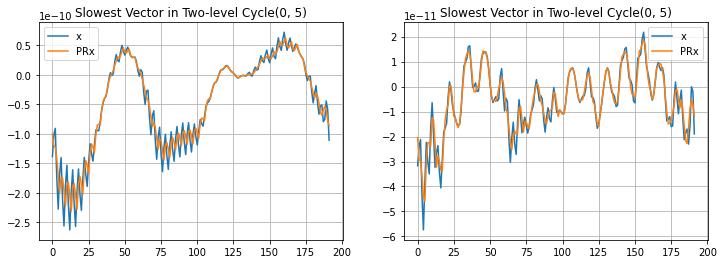

In [8]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, -1)

#### Two-level Cycle with many relaxations at coarse level

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.749e+01           2.453           11.204
INFO     1      4.482e+00  (0.163)  0.511  (0.208)  8.770
INFO     2      4.278e-01  (0.095)  0.456  (0.892)  0.939
INFO     3      6.731e-02  (0.157)  0.397  (0.872)  0.169
INFO     4      1.216e-02  (0.181)  0.421  (1.059)  0.029
INFO     5      2.362e-03  (0.194)  0.423  (1.005)  0.006
INFO     6      4.913e-04  (0.208)  0.434  (1.027)  0.001
INFO     7      1.042e-04  (0.212)  0.439  (1.011)  0.000
INFO     8      2.238e-05  (0.215)  0.440  (1.002)  0.000
INFO     9      4.853e-06  (0.217)  0.441  (1.004)  0.000
INFO     10     1.067e-06  (0.220)  0.445  (1.009)  0.000
INFO     11     2.370e-07  (0.222)  0.447  (1.005)  0.000
INFO     12     5.269e-08  (0.222)  0.447  (0.999)  0.000
INFO     13     1.169e-08  (0.222)  0.445  (0.996)  0.000
INFO     14     2.582e-09  (0.221)  0.443  (0.995)  0.000
INFO     15     5.648e-10  (0.219)  0.440  (0.992)  0.00

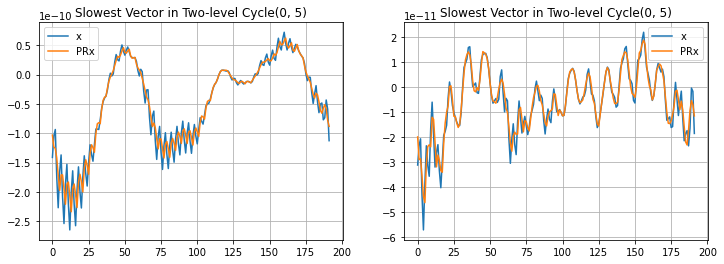

In [9]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, 0)

#### Two-level Relaxation Mini-Cycle

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.749e+01           2.453           11.204
INFO     1      4.433e+00  (0.161)  0.682  (0.278)  6.500
INFO     2      5.307e-01  (0.120)  0.225  (0.330)  2.358
INFO     3      1.575e-01  (0.297)  0.096  (0.428)  1.634
INFO     4      1.010e-01  (0.641)  0.074  (0.765)  1.369
INFO     5      7.643e-02  (0.756)  0.063  (0.855)  1.211
INFO     6      6.157e-02  (0.805)  0.056  (0.885)  1.102
INFO     7      5.200e-02  (0.845)  0.051  (0.912)  1.021
INFO     8      4.556e-02  (0.876)  0.048  (0.935)  0.956
INFO     9      4.102e-02  (0.900)  0.045  (0.954)  0.902
INFO     10     3.763e-02  (0.918)  0.044  (0.968)  0.855
INFO     11     3.498e-02  (0.929)  0.043  (0.978)  0.813
INFO     12     3.279e-02  (0.937)  0.042  (0.984)  0.774
INFO     13     3.092e-02  (0.943)  0.042  (0.988)  0.739
INFO     14     2.928e-02  (0.947)  0.041  (0.991)  0.705
INFO     15     2.780e-02  (0.950)  0.041  (0.994)  0.67

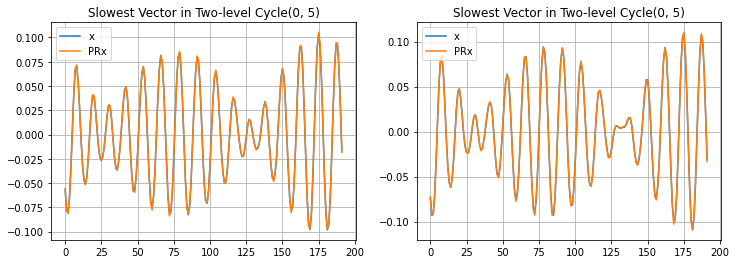

In [10]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, 5)

#### Level 1 Relaxation Shrinkage

#### $P^T A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     3.939e-01                    4.469e-01    0.884
INFO     1     1.325e-01 (0.339) [0.339]    2.959e-01    0.450 (0.514)
INFO     2     8.757e-02 (0.667) [0.473]    2.519e-01    0.352 (0.786)
INFO     3     6.291e-02 (0.718) [0.543]    2.287e-01    0.277 (0.792)
INFO     4     4.990e-02 (0.790) [0.597]    2.126e-01    0.235 (0.850)
INFO     5     4.192e-02 (0.837) [0.640]    2.003e-01    0.209 (0.888)
INFO     6     3.621e-02 (0.861) [0.673]    1.905e-01    0.190 (0.905)
INFO     7     3.195e-02 (0.881) [0.699]    1.824e-01    0.175 (0.919)
INFO     8     2.866e-02 (0.895) [0.721]    1.756e-01    0.163 (0.930)
INFO     9     2.603e-02 (0.908) [0.740]    1.698e-01    0.153 (0.939)
INFO     10    2.388e-02 (0.917) [0.756]    1.648e-01    0.145 (0.945)
INFO     11    2.209e-02 (0.925) [0.770]    1.603e-01    0.138 (0.951)
INFO     12    2.058e-02 (0.932) [0.782]    1.564e-01    0.132 (0.956)
INFO 

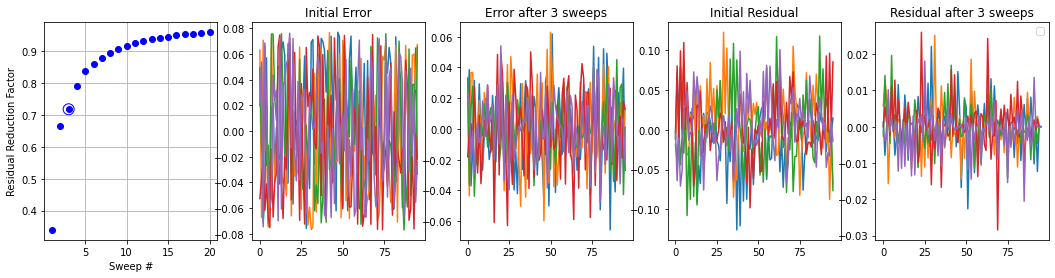

In [11]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, p.T, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

#### $Q A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.764e-01                    4.470e-01    0.619
INFO     1     1.003e-01 (0.364) [0.364]    2.759e-01    0.365 (0.591)
INFO     2     5.865e-02 (0.587) [0.461]    2.139e-01    0.276 (0.758)
INFO     3     3.660e-02 (0.623) [0.510]    1.842e-01    0.199 (0.725)
INFO     4     2.713e-02 (0.739) [0.560]    1.663e-01    0.164 (0.820)
INFO     5     2.176e-02 (0.801) [0.602]    1.540e-01    0.142 (0.865)
INFO     6     1.822e-02 (0.837) [0.636]    1.450e-01    0.127 (0.890)
INFO     7     1.576e-02 (0.866) [0.664]    1.380e-01    0.115 (0.911)
INFO     8     1.394e-02 (0.885) [0.688]    1.324e-01    0.107 (0.924)
INFO     9     1.251e-02 (0.899) [0.709]    1.277e-01    0.099 (0.933)
INFO     10    1.136e-02 (0.909) [0.727]    1.237e-01    0.093 (0.939)
INFO     11    1.041e-02 (0.917) [0.742]    1.203e-01    0.088 (0.944)
INFO     12    9.611e-03 (0.923) [0.756]    1.173e-01    0.083 (0.948)
INFO 

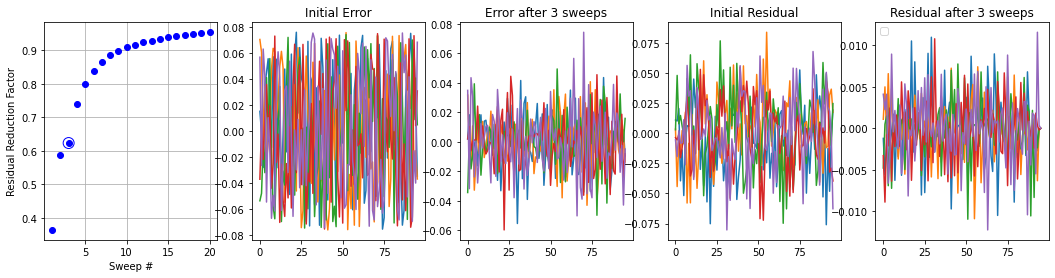

In [12]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

### Conclusions
* It is important to not exactly solve at the coarse level especially when null/near-null space components are present, in order to avoid inflating them due to round-off errors.
* $Q A P$ is as good as $R A P$ for different seeds.
* A two-level cycle (with many relaxations at the coarse level) does not reduce the RER more than relaxation. That's OK: again, many relaxations at the coarse level will affeect very smooth components and thus their aliasing.
* To see good shrinkage, use a relaxation mini-cycle (only several relaxations at the coarse level). Note that we only need one relaxation at the coarse level to get a good RER reduction (and indeed, Kaczmarz is a good smoother at level 1).

## Equation Interpretability
We (maybe) expect the coarse equations to be $U x_{i-1} + x_i + U^T x_{i+1}$ where $U$ is a rotation whose angle depends on $kh$.

In [13]:
# Normalized level 0 equations.
level.a.todense()[2, :5] / level.a.todense()[2,2]

matrix([[ 0.037, -0.59 ,  1.   , -0.59 ,  0.037]])

In [14]:
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)

print("R")
display(pd.DataFrame(r[:2, :4].todense()))
print("Q")
display(pd.DataFrame(q[:2, :4].todense()))
print("P")
display(pd.DataFrame(ml[1]._p[6:10, 2:6].todense()))
print("RAP")
display(pd.DataFrame(r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()))
print("QAP")
qap = q.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()
display(pd.DataFrame(qap))

R


,0,1,2,3
0,0.4385,0.5648,0.5549,0.4252
1,0.6336,0.2609,-0.2390,-0.6880


Q


,0,1,2,3
0,0.4553,0.5346,0.5261,0.4669
1,0.6022,0.2617,-0.1999,-0.7301


P


,0,1,2,3
0,0.5914,-0.4108,-0.0835,-0.1227
1,0.3820,-0.4921,0.0931,0.1467
2,0.1001,-0.1922,0.3823,0.4424
3,-0.0771,0.1345,0.6029,0.4034


RAP


,0,1,2,3,4,5
0,0.1543,-0.1933,-0.0773,-0.0223,0.1503,0.1731
1,0.1771,-0.1797,-0.0085,-0.7292,-0.1887,-0.1858


QAP


,0,1,2,3,4,5
0,0.1517,-0.1838,-0.0714,-0.0123,0.1517,0.1686
1,0.1686,-0.1718,-0.0123,-0.7031,-0.1838,-0.1718


In [15]:
d = qap[:, 2:4]
u = qap[:, :2]
l, v = eig(d)
#l = np.diag(np.abs(np.real(lam))**(-0.5))
#v = v.dot(l)
U = v.T.dot(u).dot(v)

In [16]:
# Off-diagonal U in U*x_{i-1} + x_i + U^T*x_{i+1} at level 1. x_i is a 2-species vector.
print("D", v.T.dot(d).dot(v))
print("U", U)

D [[-0.071  0.   ]
 [ 0.    -0.703]]
U [[ 0.152 -0.177]
 [ 0.175 -0.172]]


In [17]:
# U = V^{-1}*D*V
D, V = eig(U)
print(V, D)

[[0.71 +0.j    0.71 -0.j   ]
 [0.647-0.278j 0.647+0.278j]] [-0.01+0.07j -0.01-0.07j]


* The original diagonal block is already nearly diagonal.
* $U$ is nearly but not exactly anti-symmetric, as is the corresponding block before diagonalizing the central block.
What does it mean? Will it become symmetric in the limit of many coarsening levels?
* $U$ has real eigenvalues. In quantum mehcanics it's called "PT-symmetric" (space-time-reversible system). cf. https://math.stackexchange.com/questions/746223/besides-being-symmetric-when-will-a-matrix-have-only-real-eigenvalues, 
https://arxiv.org/pdf/1212.1861.pdf . This happens iff there exists a self-adjoint (symmetric positive definite here) $W$ such that $W U = U^* W$.

In [18]:
# Example of an SPD matrix that commutes with U. Any w in the range where (b - c*w)^2 < (d-a)^2 w works. We take w = b/c, 
# which means W is nothing but a diagonal scaling of U...
#w = U[0, 1] / U[1, 0]
#w12 = (U[0, 1] - U[1, 0] * w) / (U[1, 1] - U[0, 0])
#W = np.array([[1, w12], [w12, w]])
W = np.diag(np.sign(np.real(l))).dot(np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]]))
#W = np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]])

In [19]:
print("W", W, "W U", W.dot(U), "U^* T", U.T.dot(W), "diff", W.dot(U) - U.T.dot(W))

W [[-1.     0.   ]
 [ 0.    -1.015]] W U [[-0.152  0.177]
 [-0.177  0.174]] U^* T [[-0.152 -0.177]
 [ 0.177  0.174]] diff [[ 0.     0.355]
 [-0.355  0.   ]]


In [20]:
# After the full transformation - diagonalizing the central block and symmetrizing U:
print("D")
print(W.dot(v.T).dot(d).dot(v))
print("U") 
print(W.dot(v.T).dot(u).dot(v))

D
[[ 0.071 -0.   ]
 [-0.     0.714]]
U
[[-0.152  0.177]
 [-0.177  0.174]]


So this is rather trivial - one can always make the central block symmetric. If it is positive definite, $U$ can be made anti-symmetric via diagonal scaling of the equations.

### Spectral Comparison

In [21]:
# Minimum eigenvalue of A is machine 0.
lam = np.real(eig(level.a.todense())[0])
lam0 = lam[np.argsort(np.abs(lam))][:30]
print(lam0)
print("min", lam0[0])

[ 0.     0.     0.031  0.031 -0.033 -0.033  0.06   0.06  -0.068 -0.068  0.087  0.087 -0.106 -0.106  0.111  0.111  0.134  0.134 -0.145 -0.145  0.154  0.154  0.172  0.172 -0.187 -0.187  0.188  0.188  0.202  0.202]
min 3.9547534157186197e-16


In [22]:
# Minimum eigenvalue of RAP is small but non-zero.
ac = r.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam1 = lam[np.argsort(np.abs(lam))][:30]
print(lam1)
print("min", lam1[0])

[ 0.     0.     0.032  0.032 -0.034 -0.034  0.061  0.061 -0.07  -0.07   0.087  0.087 -0.108 -0.108  0.111  0.111  0.133  0.133 -0.148 -0.148  0.152  0.152  0.168  0.168  0.183  0.183 -0.19  -0.19   0.195  0.195]
min 0.00028034836865887343


In [23]:
# Minimum eigenvalue of QAP is the same.
ac = q.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam2 = lam[np.argsort(np.abs(lam))][:30]
print(lam2)
print("min", lam2[0])

[-0.001 -0.001  0.03   0.03  -0.035 -0.035  0.059  0.059 -0.071 -0.071  0.086  0.086 -0.109 -0.109  0.111  0.111  0.133  0.133 -0.149 -0.149  0.152  0.152  0.17   0.17   0.185  0.185 -0.19  -0.19   0.198  0.198]
min -0.001454761860690117


In [24]:
# High order operator eigenvalue of P^T*A*P i sthe same.
ac = ml[1]._p.T.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam3 = lam[np.argsort(np.abs(lam))][:30]
print(lam3)
print("min", lam2[0])

[-0.001 -0.001  0.031  0.031 -0.035 -0.035  0.06   0.06  -0.071 -0.071  0.087  0.087 -0.109 -0.109  0.112  0.112  0.134  0.134 -0.15  -0.15   0.154  0.154  0.172  0.172  0.187  0.187 -0.192 -0.192  0.2    0.2  ]
min -0.001454761860690117


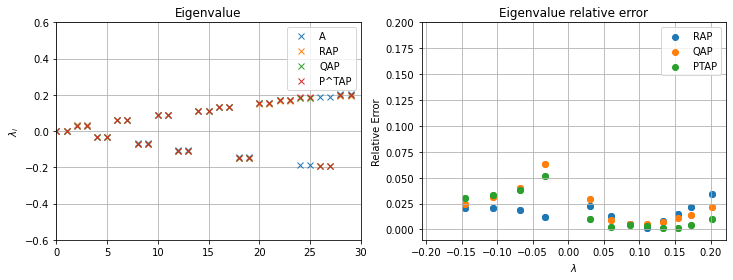

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.plot(lam0, "x", label="A")
ax.plot(lam1, "x", label="RAP")
ax.plot(lam2, "x", label="QAP")
ax.plot(lam3, "x", label="P^TAP")
ax.grid(True);
ax.legend();
ax.set_xlim([0, 30]);
ax.set_ylim([-0.6, 0.6]);
ax.set_title("Eigenvalue");
ax.set_ylabel("$i$")
ax.set_ylabel("$\lambda_i$")

ax = axs[1]
ax.scatter(lam0, np.abs(lam1 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="RAP")
ax.scatter(lam0, np.abs(lam2 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="QAP")
ax.scatter(lam0, np.abs(lam3 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="PTAP")
ax.grid(True);
ax.legend();
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Relative Error")
ax.set_ylim([-0.01, 0.2]);
ax.set_title("Eigenvalue relative error");

Here we can clearly see that $QAP$ is a compromise between sparsity and accuracy: $P^T A P$ approximates many more eigenvalues accurately. It is unexpected that neither $P^T A P$ nor $R A P$ is exactly singular while $Q A P$ is (once again explaining while a direct coarse level solve is especially bad with $Q A P$).

## Auto-setup

In [26]:
# multilevel = hm.setup.auto_setup.setup(level.a, level.location, domain_size, max_levels=2, 
#                                        repetitive=True, symmetrize=True,
#                                       num_bootstrap_steps=1, caliber=4)

In [27]:
ml = hm.setup.hierarchy.multilevel.Multilevel.create(level)

for l in range(3):
    ml1 = helmholtz.analysis.stats.coarsen_qap(ml[-1], nu, 
                           domain_size,
                           aggregate_size, num_components,
                           ideal_tv=ideal_tv,
                           num_examples=num_examples,
                           interpolation_method=interpolation_method,
                           fit_scheme=fit_scheme,
                           weighted=weighted,
                           neighborhood=neighborhood,
                           repetitive=repetitive,
                           m=m,
                           use_q=False)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(ml1[0], ml1[1]._r, nu) for nu in nu_values])
    print(mock_conv)
    two_level_conv = np.array([hm.repetitive.locality.two_level_conv_factor(
        ml1, nu, nu_coarsest=-1, print_frequency=None)[1] for nu in nu_values])
    print(two_level_conv)
    ml.add(ml1[1])

AttributeError: module 'helmholtz.analysis.stats' has no attribute 'coarsen_qap'

In [ ]:
# Using GMRES as as a coarse-level solver seems to be a robust choice vs. m (domain size).
m = None
nu_coarsest = -1
hm.repetitive.locality.two_level_conv_factor(
    ml, 8, num_levels=3,
    nu_coarsest=200, print_frequency=1, debug=False, num_sweeps=10);